In [1]:
# In order to have a reference line, a base model will be trained with face cropped and aligned for bonafide vs printed vs screen classes (3 classes).
# - obj: train over FLICKR and eval with FLICKR

# take json files and gather data to training format -> bonafide vs imposter

In [2]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils.paths import list_images
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

In [3]:
datapath = '../data/02_intermediate/flickr'
images_list = [*list_images(datapath)]
_classes = ('attack', 'bonafide')
_bf_index = _classes.index('bonafide')

In [4]:
_size = (224, 224)
bf, att = [], []

for imdir in images_list:
    if _classes[_bf_index] in imdir.split(os.sep): # if 'bonafide' in imdir
        bf.append(imdir)
    else:
        att.append(imdir)

In [5]:
len(bf), len(att)

(3000, 10975)

In [6]:
bf[0]

'../data/02_intermediate/flickr/bonafide/originales_ronda3y4/F16146.png'

In [7]:
def _parse_function(impath):
    # image reading
    image_string = tf.io.read_file(impath)
    image_decoded = tf.io.decode_png(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    image = tf.image.resize(image, _size)
    image = image / 255.
    
    # label setting
    _split = tf.strings.split(impath, sep=os.sep)
    _cls = _split[4]
    # 4th element is class id
    if _cls == 'bonafide':
        lb = tf.cast([1, 0], tf.float32)
    else:
        lb = tf.cast([0, 1], tf.float32)
    
    return image, lb

# How to make dataset

In [30]:
batch_size = 16
dataset = tf.cast(images_list, dtype=tf.string)
dataset = tf.data.Dataset.from_tensor_slices(dataset)
dataset = dataset.shuffle(batch_size)
dataset = dataset.map(_parse_function)
dataset = dataset.cache()
dataset = dataset.batch(batch_size)

  0%|                                                                                                                                                                                      | 0/874 [00:02<?, ?it/s]


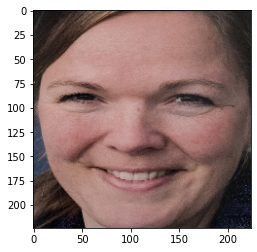

In [31]:
for bs in tqdm(dataset):
    im, lb = bs
    
    # print(lb)
    plt.imshow(im[0])
        
    break

In [32]:
# def train, test, val sets # done

In [33]:
bf_y = np.ones(len(bf))
att_y = np.zeros(len(att))

In [34]:
bf_y.shape, att_y.shape

((3000,), (10975,))

In [35]:
X = np.concatenate([bf, att])
y = np.concatenate([bf_y, att_y])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [37]:
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([6602, 1783]))

# Train data

In [38]:
train_dataset = tf.cast(X_train, dtype=tf.string)
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(batch_size)
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.batch(batch_size)

# Val data

In [39]:
val_dataset = tf.cast(X_val, dtype=tf.string)
val_dataset = tf.data.Dataset.from_tensor_slices(val_dataset)
val_dataset = val_dataset.shuffle(batch_size)
val_dataset = val_dataset.map(_parse_function)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(1)

# Test data

In [40]:
# test_dataset = tf.cast(X_test, dtype=tf.string)
# test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
# test_dataset = val_dataset.shuffle(batch_size)
# test_dataset = val_dataset.map(_parse_function)
# test_dataset = val_dataset.cache()
# test_dataset = val_dataset.batch(1)

  0%|                                                                                                                                                                                      | 0/525 [00:00<?, ?it/s]

GT label: [1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1]


2022-10-27 18:48:32.124883: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
  0%|                                                                                                                                                                                      | 0/525 [00:02<?, ?it/s]


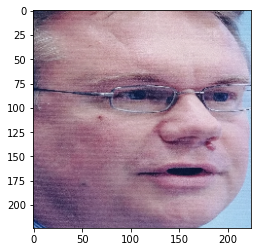

In [41]:
for bs in tqdm(train_dataset):
    im, lb = bs
    
    print('GT label:', np.argmax(lb, axis=-1))
    plt.imshow(im[0])
        
    break

In [20]:
# def model to be trained
# use aikit structure

In [21]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [43]:
input_shape = (*_size, 3) # 224x224x3

model = MobileNetV2(input_shape=input_shape, alpha=1.0, include_top=False, weights=None, pooling='max')

In [44]:
x = model.output
# Added by the 'pooling' argument
# x = GlobalAveragePooling2D()(x)
x = Dense(units=2, activation="softmax", use_bias=True, name="Logits")(x)

model = Model(inputs=model.input, outputs=x)

In [45]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [46]:
from tensorflow.keras.metrics import CategoricalAccuracy

In [47]:
# compile model

learning_rate = 1e-3

# optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True, decay=1e-5)
optimizer = Adam(learning_rate=learning_rate, amsgrad=True, decay=1e-6)
loss = 'categorical_crossentropy'

model.compile(
    optimizer=optimizer, 
    loss=loss, 
    metrics=['acc', ], 
)

In [49]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=15, use_multiprocessing=True, workers=12)

Epoch 1/15
525/525 [==============================] - 734s 1s/step - loss: 0.6346 - acc: 0.7503 - val_loss: 0.7413 - val_acc: 0.2161
Epoch 2/15
525/525 [==============================] - 90s 170ms/step - loss: 0.4114 - acc: 0.8266 - val_loss: 0.8054 - val_acc: 0.2161
Epoch 3/15
525/525 [==============================] - 101s 193ms/step - loss: 0.3443 - acc: 0.8600 - val_loss: 0.9637 - val_acc: 0.2161
Epoch 4/15
525/525 [==============================] - 107s 205ms/step - loss: 0.3104 - acc: 0.8772 - val_loss: 1.0154 - val_acc: 0.2161
Epoch 5/15
525/525 [==============================] - 114s 217ms/step - loss: 0.2617 - acc: 0.8993 - val_loss: 1.0985 - val_acc: 0.2161
Epoch 6/15
525/525 [==============================] - 114s 218ms/step - loss: 0.1726 - acc: 0.9344 - val_loss: 1.1986 - val_acc: 0.2161
Epoch 7/15
525/525 [==============================] - 118s 225ms/step - loss: 0.1533 - acc: 0.9399 - val_loss: 1.1083 - val_acc: 0.2161
Epoch 8/15
525/525 [==============================] 